# Excercise 15.7 A first ant-colony optimization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

In [3]:
def branch_decision_rule(current_node,tau,D,M,alpha,beta):
    i =   current_node
    #Check connected node
    possible_next_node = []
    for index, value in enumerate(M[i]):
        if value == 1:
            possible_next_node.append(index)

    prob_next_node = np.zeros(len(possible_next_node))

    for j in range(len(possible_next_node)):
        w = 1/D[i,possible_next_node[j]]
        prob_next_node[j] =  tau[i,possible_next_node[j]]**(alpha)*w**beta #eq 15.2
    
    total_prob_next = sum(prob_next_node)
    prob_next_node = prob_next_node/total_prob_next         
    
    next_node = np.random.choice(possible_next_node,p = prob_next_node)

    return next_node


In [5]:
def simplify_sequence(sequence):
    '''result = []
    for i in range(len(sequence)):
        if sequence[i] in sequence[i + 1:]:
            i = sequence.index(sequence[i], i + 1)
        else:
            result.append(sequence[i])
    return result'''
    result = []
    i = 0
    while i < len(sequence):
        if sequence[i] in sequence[i + 1 :]: 
            i = sequence.index(
                sequence[i], i + 1
            )  
        else:
            result.append(
                sequence[i]
            )  
            i += 1
    return result

In [6]:
def get_distance(path,D):
    total_distance = 0
    for i in range(len(path)-1):
        total_distance += D[path[i], path[i+1]]
    
    return total_distance

In [20]:
def plot_path(path, position, start, destination, title):

    path = simplify_sequence(path)

    plt.figure(figsize=(7, 7))
    plt.plot(position[:, 0], position[:, 1], "o",color = 'k')
    plt.plot(position[start, 0], position[start, 1], "o", color="g")  # starting point
    plt.plot(position[destination, 0], position[destination, 1], "o", color="r")  # destination point
    plt.title(title)

    for ind, i in enumerate(path):
        if ind < len(path) - 1:
            j = path[ind + 1]
            plt.plot([position[i, 0], position[j, 0]], [position[i, 1], position[j, 1]], linewidth=2, c="b")

    plt.axis("off")
    plt.show()


In [76]:

def update_pheromone(A,f0,D,paths,paths_length,tau):
    for i in range(A):
        if f0 in paths[i]:
            paths[i] = simplify_sequence(paths[i])
            path_length = get_distance(paths[i],D)
            paths_length.append(path_length)

            for j in range(len(paths[i])-1):
                Q = 1
                tau[paths[i][j], paths[i][j+1]] += Q/path_length        # Q = 1
                tau[paths[i][j+1], paths[i][j]] += Q/path_length        # Q = 1
    return tau

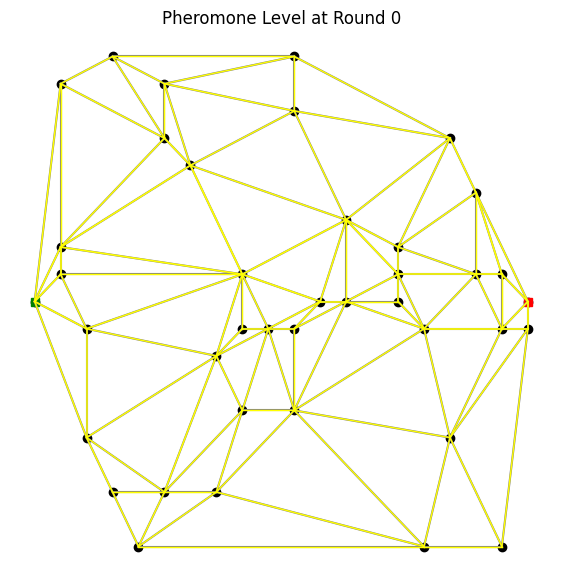

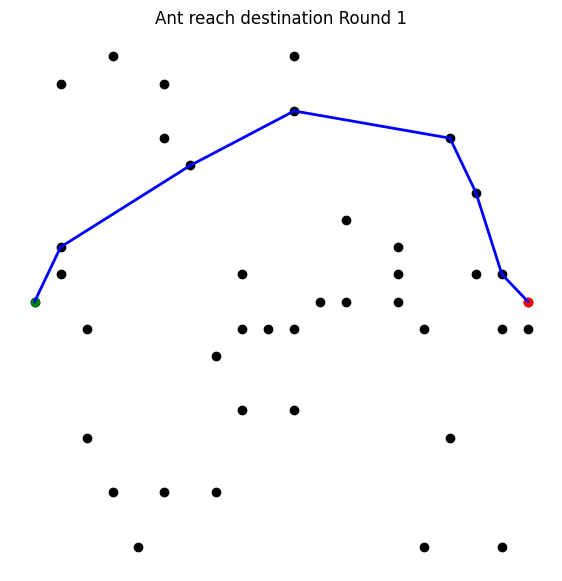

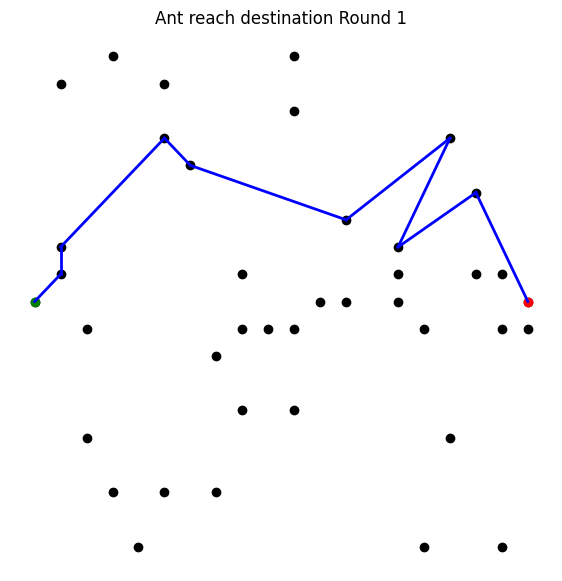

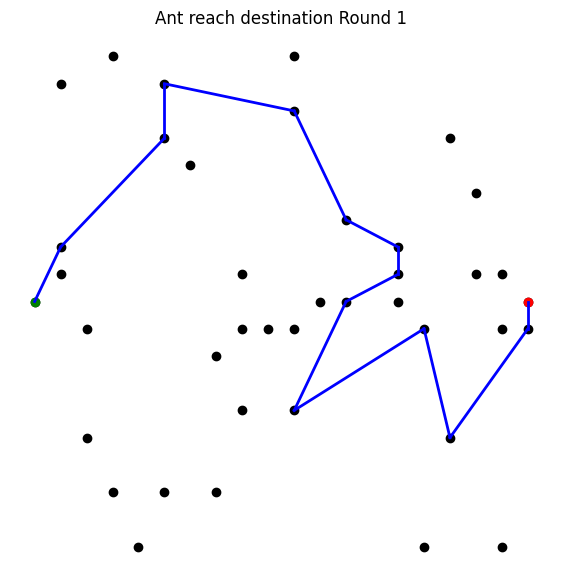

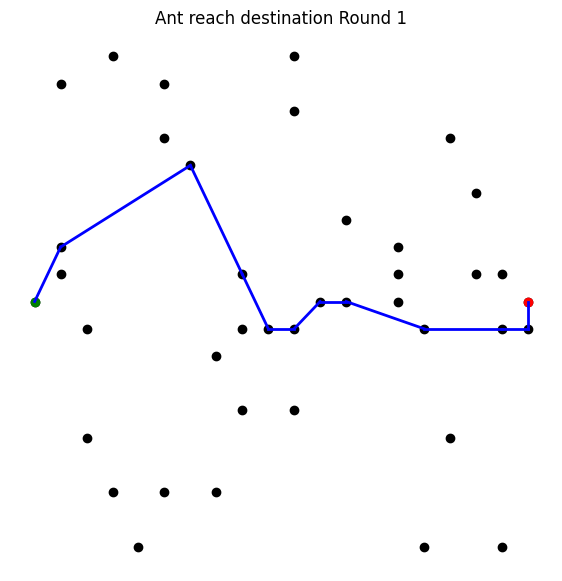

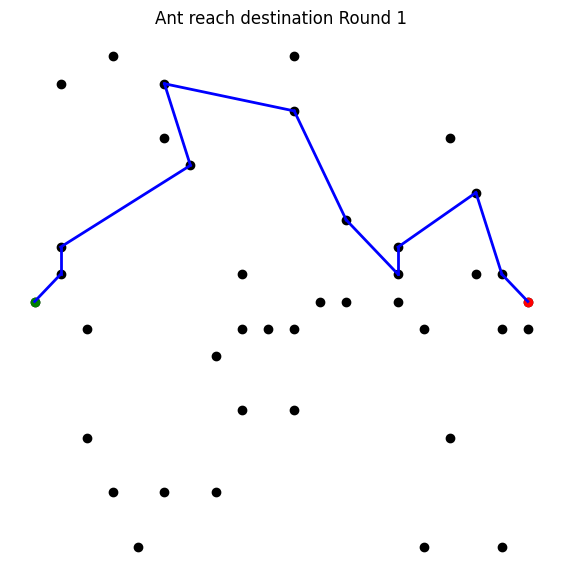

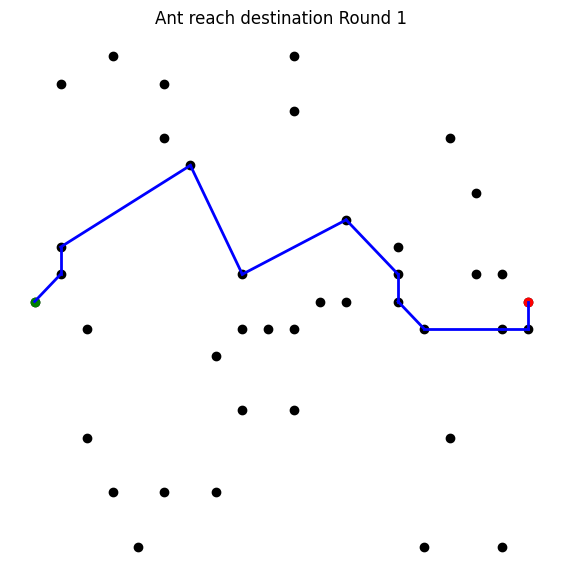

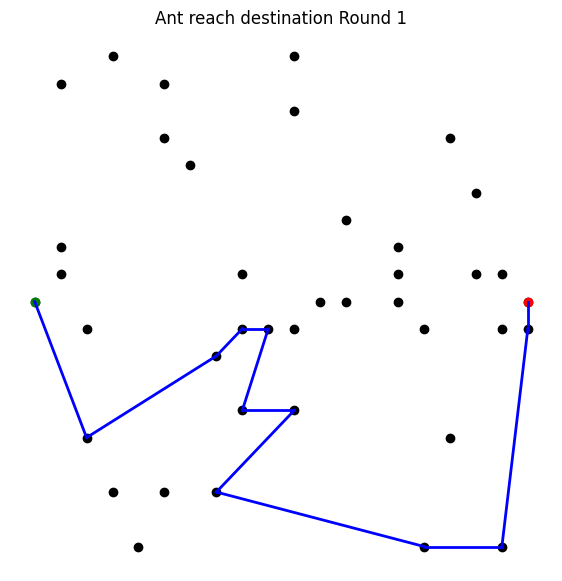

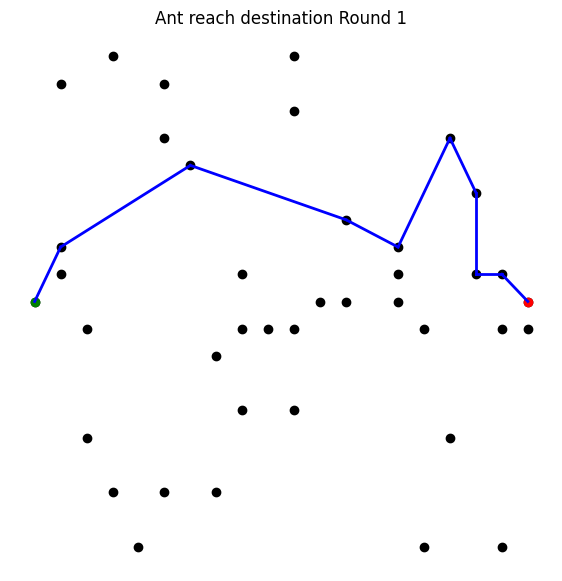

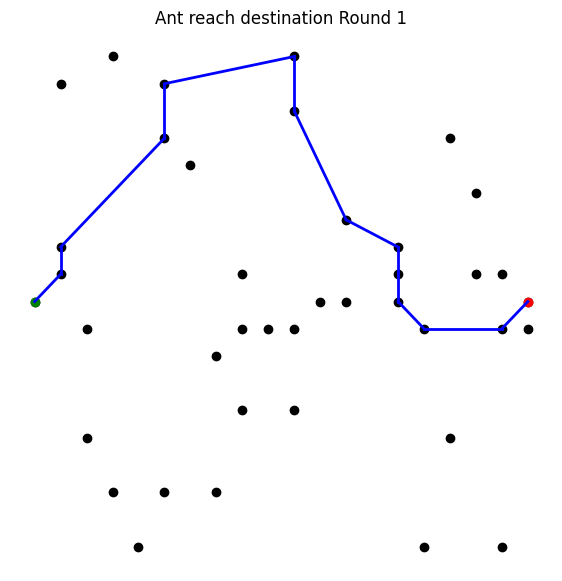

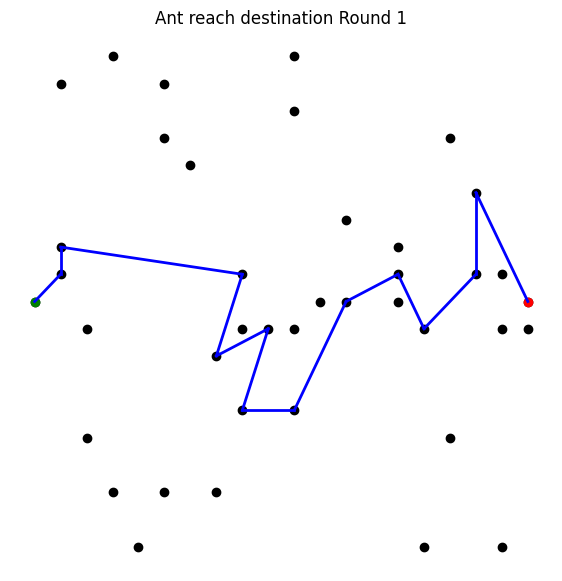

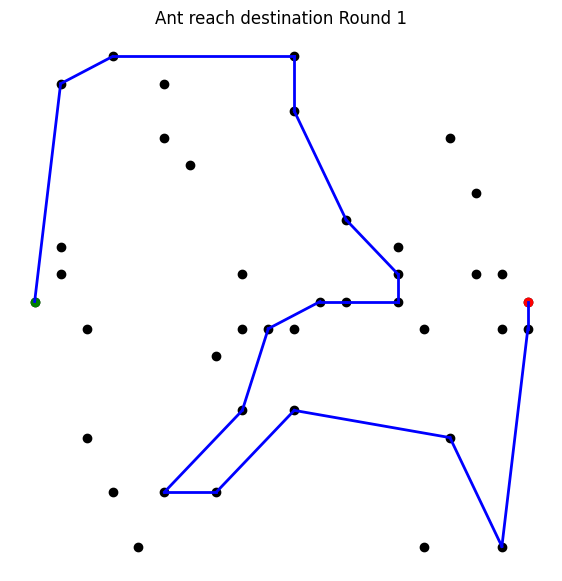

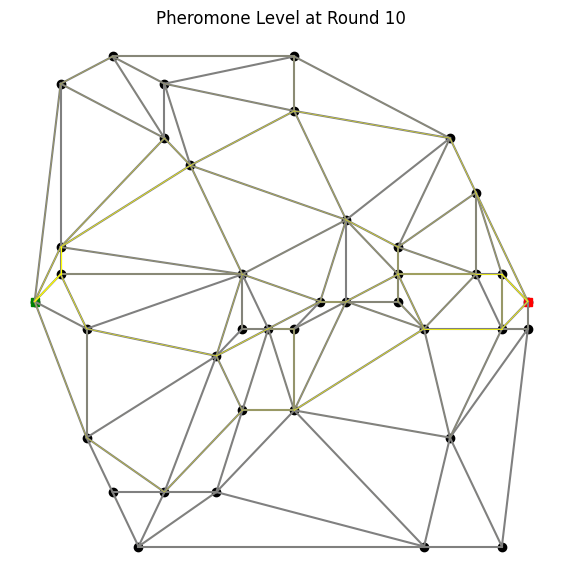

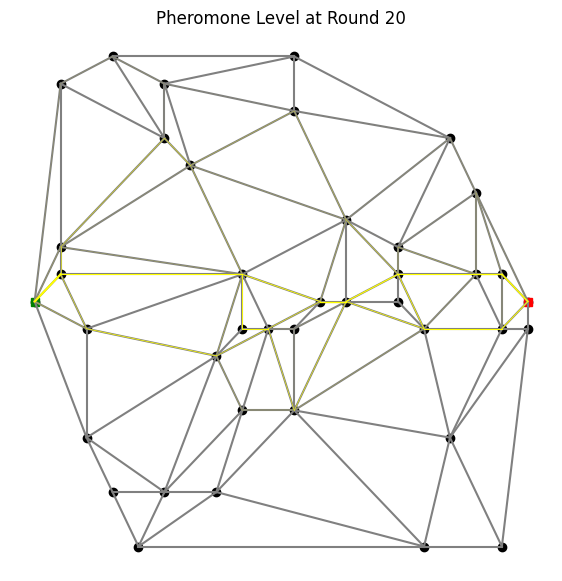

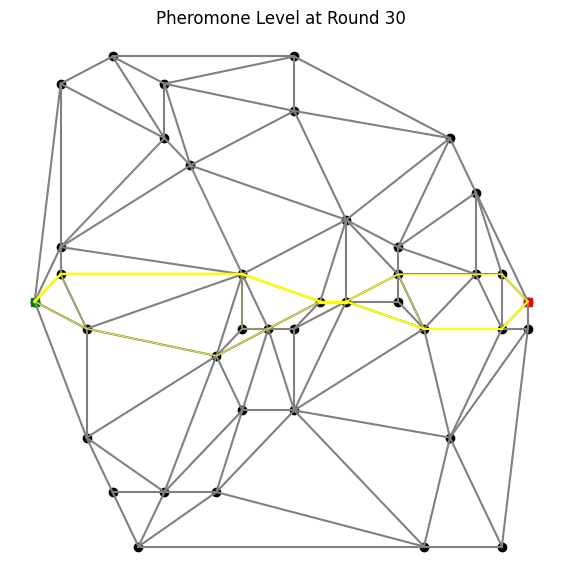

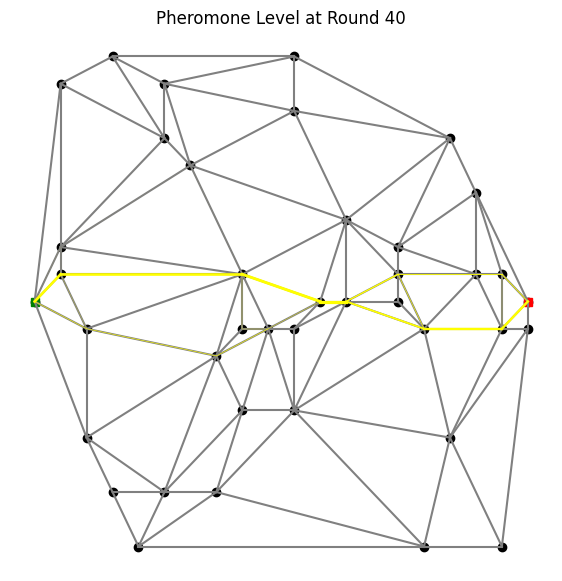

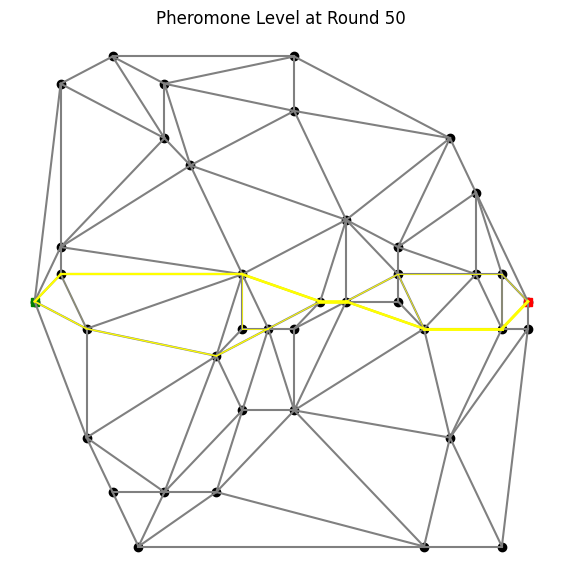

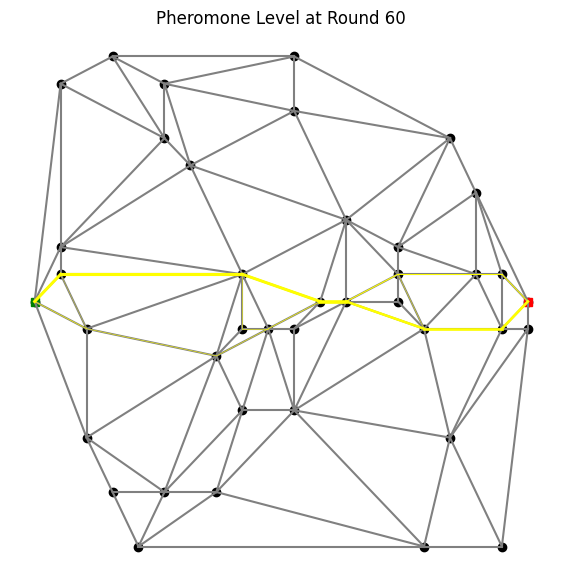

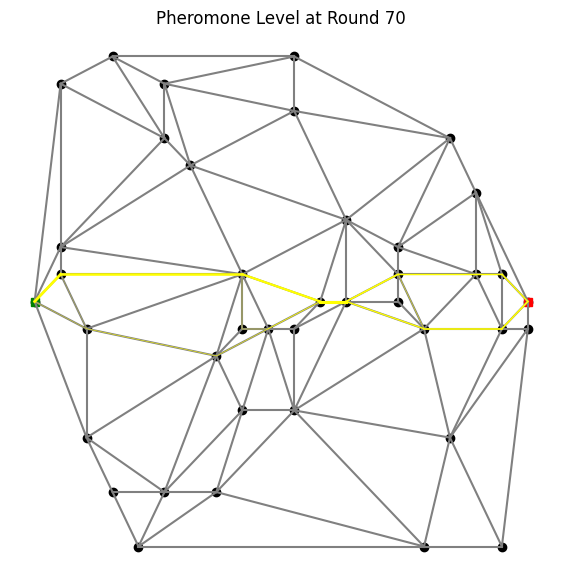

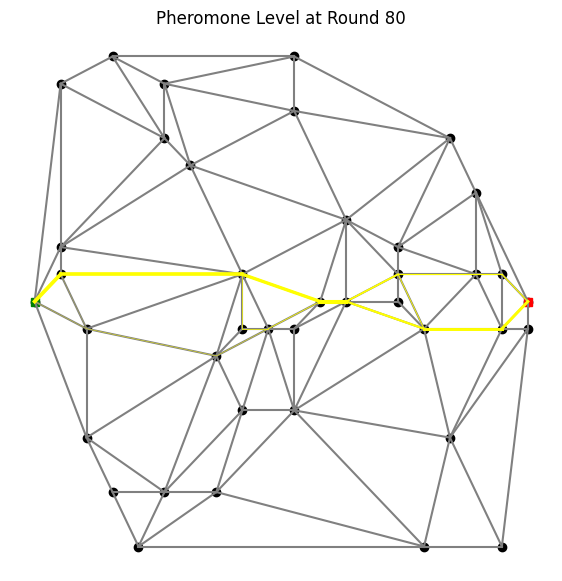

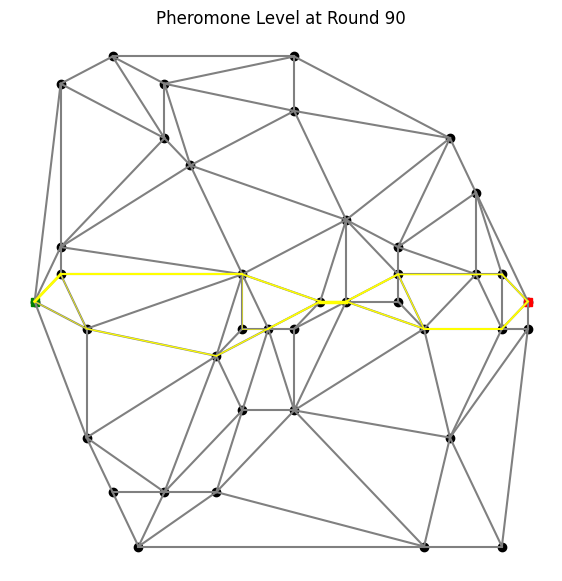

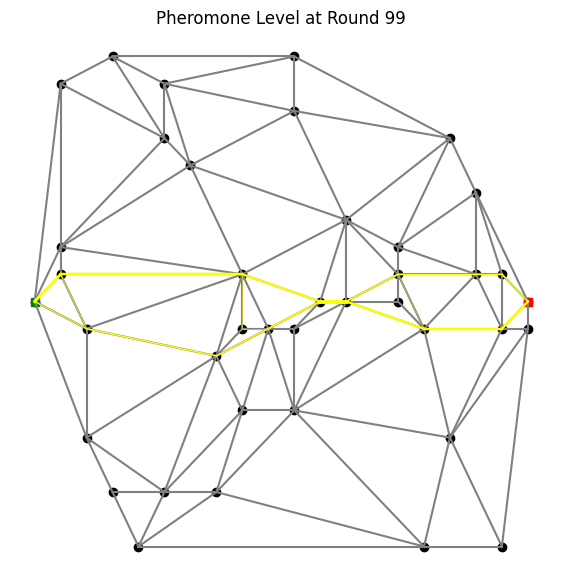

Text(0.5, 1.0, 'N-points:40 α:0.8 β:1.0  ρ:0.5  Ants :20 Step:80 Iterations:100 ')

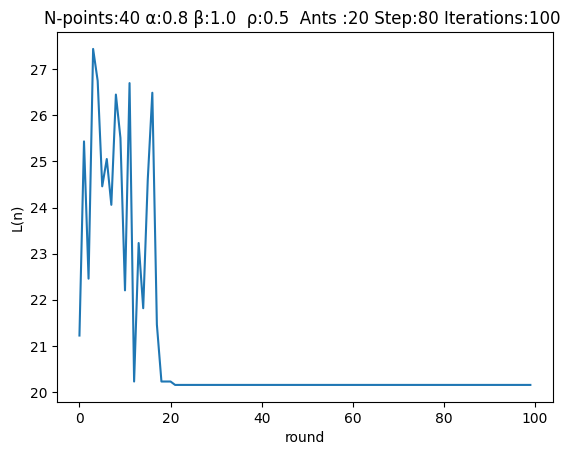

In [57]:
# exercise 15.7
#######################
# Parameters
N = 40      # number of points
A = 20      # number of ants
S = 80      # maximum steps
alpha = 0.8
beta = 1.0 
rho = 0.5
iteration_num = 100
#######################

# generate 20x20 plane for all points
points = []
for i in range(20):
    for j in range(20):
        points.append([i,j])

# generate positions for each points
random_ind = np.random.choice(len(points), N, replace=False)
position = []
for i in random_ind:
    position.append(points[i])
position = np.array(position)

# create Delaunay triangulation
delaunay_tri = Delaunay(position )

# create connection matrix
M = np.zeros((N,N))

for simplice in delaunay_tri.simplices:
    for i in range(len(simplice)):
        for j in range(i+1,len(simplice)):
            M[simplice[i], simplice[j]] = 1     # set equal to one for direct connections, zero for elsewhere
            M[simplice[j], simplice[i]] = 1
            
tau = M          # tau = M at the beginning

# create distance Matrix
D = np.zeros((N,N))
for i in range(N):
    for j in range(i+1,N):
        D[i,j] = np.linalg.norm(position [i] - position[j])
        D[j,i] = D[i,j]

for i in range(N):
    for j in range(i+1, N):
        if M[i,j] == 0:             # distance inf for disconnected point
            D[i,j] = np.inf
            D[j,i] = np.inf     

# create weith matrix
W = np.zeros((N,N))
for i in range(N):
    for j in range(i+1,N):
        W[i,j] = 1/D[i,j]

####################################################################

best_paths = {'distance' : [], 'sequence': []}

s0 = np.random.randint(0, N) # starting point
f0 = np.random.randint(0, N) # destination point
'''check_distance = 0 
while check_distance < 10:              
    s0 = np.random.randint(0, N) # starting point
    f0 = np.random.randint(0, N) # destination point
    check_distance = np.linalg.norm(random_position[f0] - random_position[s0])'''

for iteration in range(iteration_num):
    paths = []
    paths_length = []
    tau = (1-rho)*tau

    for i in range(A):
        paths.append([s0])      #collect starting point
        for s in range(S):
            current_node = paths[i][-1]
            next_node = branch_decision_rule(current_node,tau,D,M,alpha,beta)
            paths[i].append(next_node)
            if next_node == f0: # check if any ants reached the target
                if iteration == 1:
                    plot_path(paths[i],position,s0,f0, title = "Ant reach destination Round 1")
                break
    

    # updata pheromone matrix
    tau = update_pheromone(A,f0,D,paths,paths_length,tau)
    
    #Save best path
    best_paths["sequence"].append(paths[np.argmin(paths_length)])
    best_paths["distance"].append(min(paths_length))

    if iteration % 10 == 0 or iteration == iteration_num - 1:
        plt.figure(figsize=(7, 7))
        plt.plot(position[:, 0], position[:, 1], "o", color='k')
        plt.plot(position[s0, 0], position[s0, 1], "s", color="g")  # starting point
        plt.plot(position[f0, 0], position[f0, 1], "s", color="r")  # destination point
        
        for i in range(N):
            for j in range(i + 1, N):
                if M[i, j] == 1:
                    plt.plot([position[i, 0], position[j, 0]], [position[i, 1], position[j, 1]], color="gray")

        for i in range(N):
            for j in range(i + 1, N):
                plt.plot([position[i, 0], position[j, 0]], [position[i, 1], position[j, 1]], "yellow", linewidth=tau[i, j] * 2)

        plt.title("Pheromone Level at Round " + str(iteration))
        plt.axis("off")
        plt.show()

plt.plot(best_paths["distance"])
plt.ylabel("L(n)")
plt.xlabel("round")
plt.title("N-points:{} α:{} β:{}  ρ:{}  Ants :{} Step:{} Iterations:{} ".format(N, alpha,beta, rho, A, S, iteration_num))
    

In [9]:
delaunay_tri.simplices

array([[ 7, 30, 10],
       [30, 20, 10],
       [ 9, 34, 21],
       [28, 29, 21],
       [ 2, 11, 32],
       [27,  2, 32],
       [28, 35, 32],
       [35, 27, 32],
       [30, 17, 20],
       [17, 34, 20],
       [17, 30,  7],
       [26, 17, 24],
       [17, 26, 34],
       [26, 25, 34],
       [26, 23, 25],
       [23, 26,  0],
       [34, 22, 20],
       [16,  9, 21],
       [29, 16, 21],
       [14, 17,  7],
       [35,  3, 27],
       [ 3, 35, 28],
       [34, 37, 21],
       [25, 37, 34],
       [ 2, 36, 11],
       [36, 38, 11],
       [ 6, 38,  5],
       [ 6, 26, 24],
       [26,  6,  5],
       [38,  6, 13],
       [13,  6, 24],
       [20, 31, 10],
       [31, 22, 10],
       [22, 31, 20],
       [39,  4, 10],
       [22, 39, 10],
       [ 4, 39,  9],
       [39, 34,  9],
       [39, 22, 34],
       [12, 18, 10],
       [ 4, 12, 10],
       [37, 33, 21],
       [33, 37,  3],
       [23, 15, 25],
       [15, 37, 25],
       [ 3, 19, 27],
       [37, 19,  3],
       [15, 1

# Exercise 15.8 Larger graphs

In [59]:
#excercise 15.8
def ACO_simulation(num_points,num_ants,max_steps,alpha_parameter,beta_parameter,rho_paramter,iterations):
    
    N = num_points      # number of points
    A = num_ants      # number of ants
    S = max_steps      # maximum steps
    alpha = alpha_parameter
    beta = beta_parameter 
    rho = rho_paramter
    iteration_num = iterations

    # generate 20x20 plane for all points
    points = []
    for i in range(20):
        for j in range(20):
            points.append([i,j])

    # generate positions for each points
    random_ind = np.random.choice(len(points), N, replace=False)
    position = []
    for i in random_ind:
        position.append(points[i])
    position = np.array(position)

    # create Delaunay triangulation
    delaunay_tri = Delaunay(position )

    # create connection matrix
    M = np.zeros((N,N))

    for simplice in delaunay_tri.simplices:
        for i in range(len(simplice)):
            for j in range(i+1,len(simplice)):
                M[simplice[i], simplice[j]] = 1     # set equal to one for direct connections, zero for elsewhere
                M[simplice[j], simplice[i]] = 1
                
    tau = M          # tau = M at the beginning

    # create distance Matrix
    D = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            D[i,j] = np.linalg.norm(position [i] - position[j])
            D[j,i] = D[i,j]

    for i in range(N):
        for j in range(i+1, N):
            if M[i,j] == 0:             # distance inf for disconnected point
                D[i,j] = np.inf
                D[j,i] = np.inf     

    # create weith matrix
    W = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            W[i,j] = 1/D[i,j]

    ####################################################################

    best_paths = {'distance' : [], 'sequence': []}

    
    check_distance = 0 
    while check_distance < 10:              
        s0 = np.random.randint(0, N) # starting point
        f0 = np.random.randint(0, N) # destination point
        check_distance = np.linalg.norm(position[f0] - position[s0])

    for iteration in range(iteration_num):
        paths = []
        paths_length = []
        tau = (1-rho)*tau

        for i in range(A):
            paths.append([s0])      #collect starting point
            for s in range(S):
                current_node = paths[i][-1]
                next_node = branch_decision_rule(current_node,tau,D,M,alpha,beta)
                paths[i].append(next_node)

                if next_node == f0:
                    break
        
        # updata pheromone matrix
        tau = update_pheromone(A,f0,D,paths,paths_length,tau)
        
        #Save best path
        try:
            best_paths["sequence"].append(paths[np.argmin(paths_length)])
            best_paths["distance"].append(min(paths_length))
        except:
            pass

        if iteration == iteration_num - 1:
            plt.figure(figsize=(7, 7))
            plt.plot(position[:, 0], position[:, 1], "o", color = 'k')
            plt.plot(position[s0, 0], position[s0, 1], "s", color="yellow")  # starting point
            plt.plot(position[f0, 0], position[f0, 1], "s", color="r")  # destination point
            
            for i in range(N):
                for j in range(i + 1, N):
                    if M[i, j] == 1:
                        plt.plot([position[i, 0], position[j, 0]], [position[i, 1], position[j, 1]], color = 'gray')

            for i in range(N):
                for j in range(i + 1, N):
                    plt.plot([position[i, 0], position[j, 0]], [position[i, 1], position[j, 1]], "yellow", linewidth=tau[i, j] * 2)

            plt.title("Pheromone Level at Round " + str(iteration+1))
            plt.plot(position[s0, 0], position[s0, 1], "s", color="g")  # starting point
            plt.plot(position[f0, 0], position[f0, 1], "s", color="r")  # destination point
            plt.axis("off")
            plt.show()

    plt.plot(best_paths["distance"])
    plt.ylabel("L(n)")
    plt.xlabel("round")
    plt.title("N-points:{} α:{} β:{}  ρ:{}  Ants :{} Step:{} Iterations:{} ".format(N, alpha,beta, rho, A, S, iteration_num))
    plt.show()
    

number of points : 60


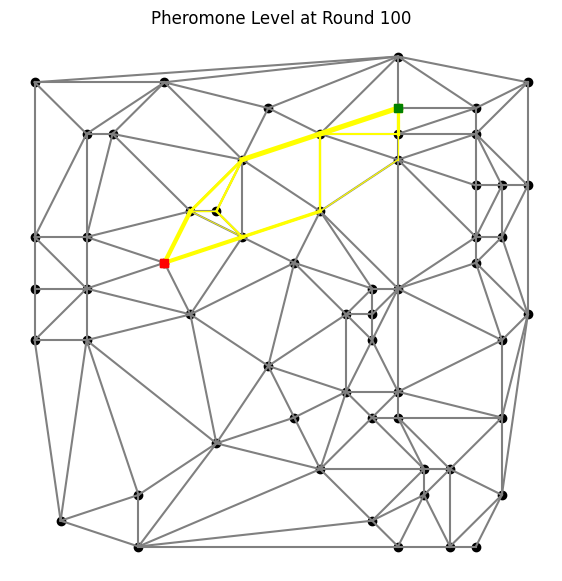

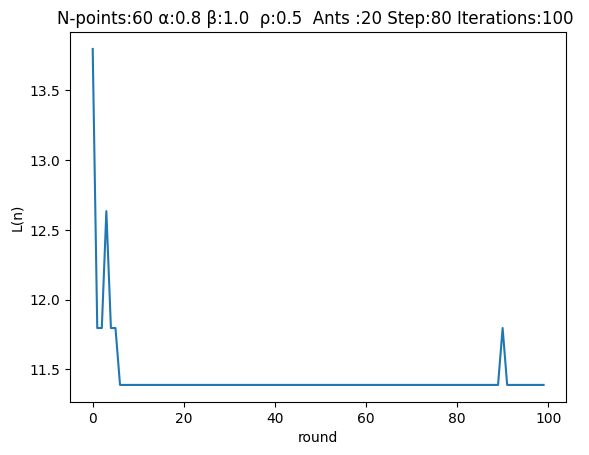

number of points : 120


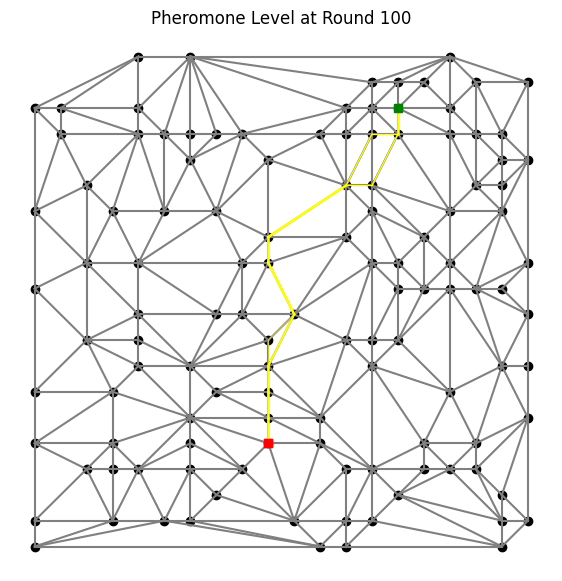

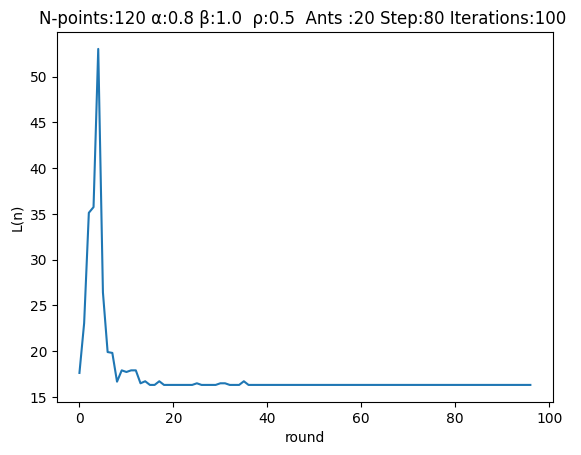

number of points : 180


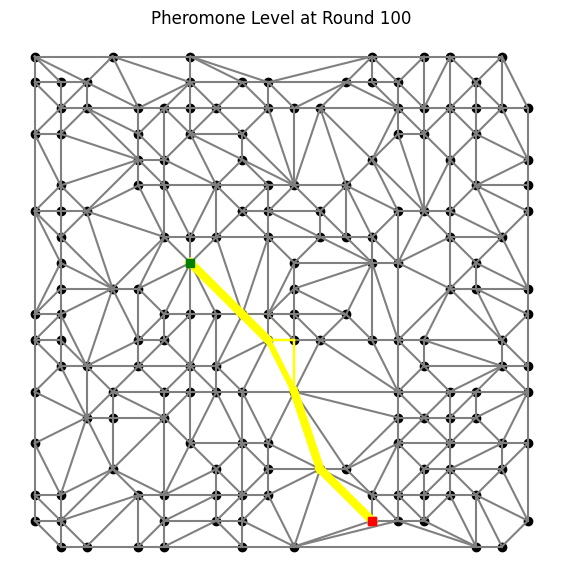

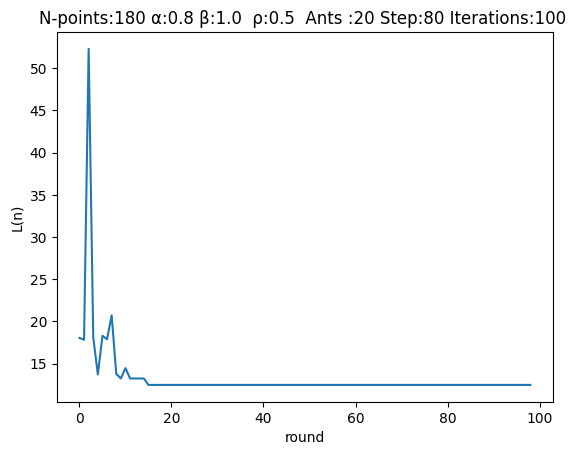

In [60]:
#def ACO_simulation(num_points,num_ants,max_steps,alpha_parameter,beta_parameter,rho_paramter,iterations):
N_list = [60,120,180]
for N in N_list:
    print(f"number of points : {N}")
    ACO_simulation(
        num_points=N,
        num_ants=A,
        max_steps=S,
        alpha_parameter=alpha,
        beta_parameter=beta,
        rho_paramter=rho,
        iterations= iteration_num
    )

### 15.8 c 

#### change alpha

alpha value : 0.1


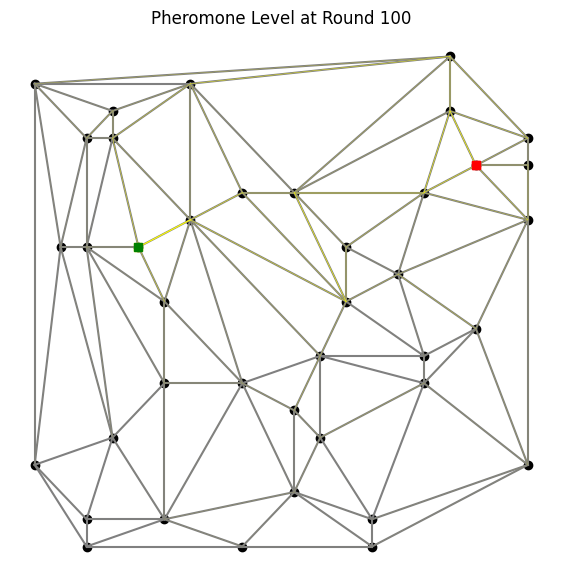

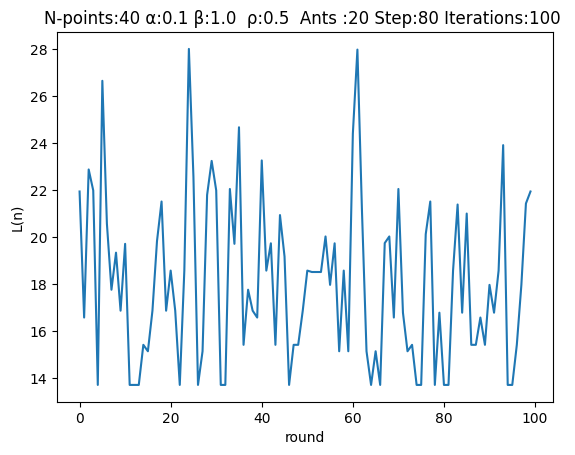

alpha value : 0.4


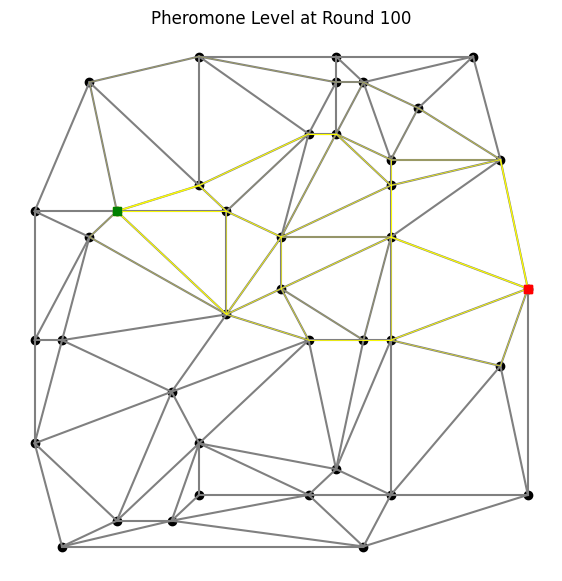

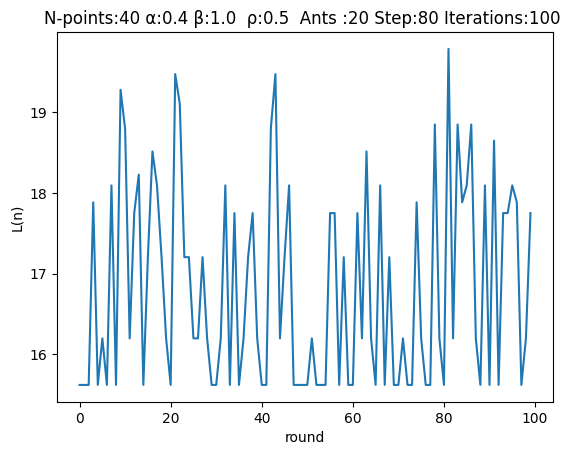

alpha value : 0.8


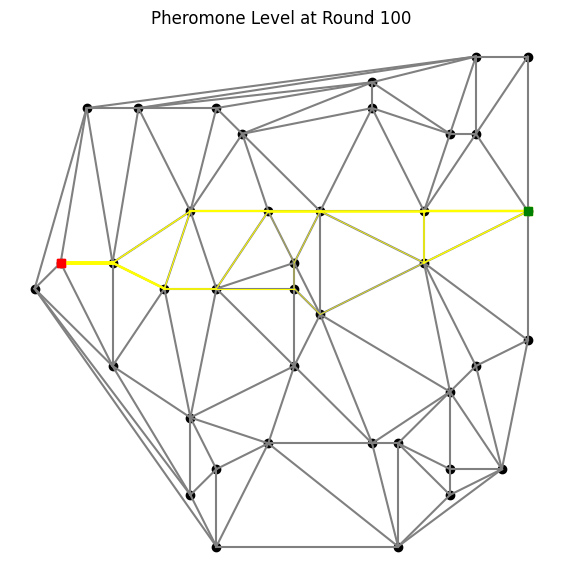

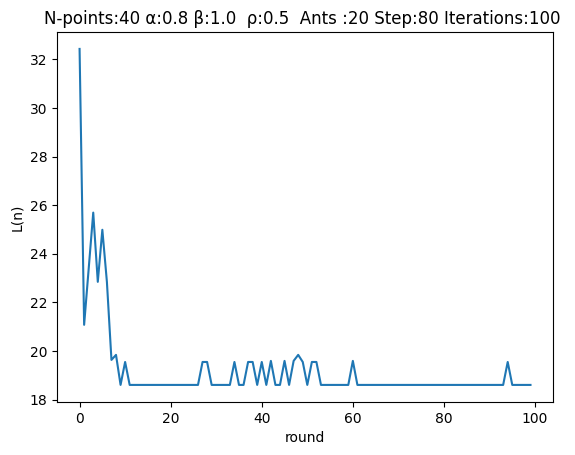

alpha value : 0.9


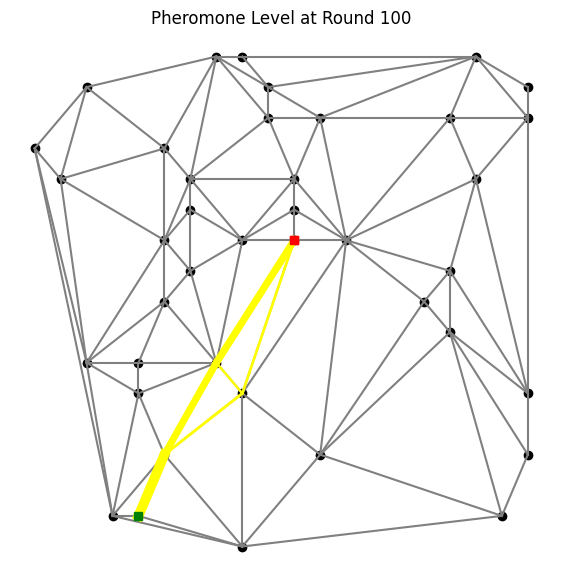

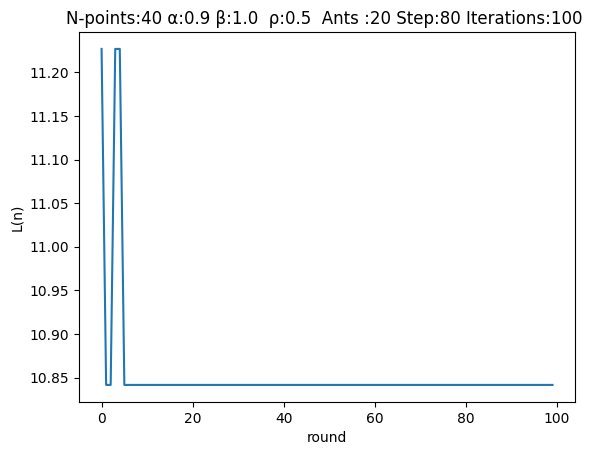

In [61]:
N = 40
alpha_list = [0.1,0.4,0.8,0.9]
#def ACO_simulation(num_points,num_ants,max_steps,alpha_parameter,beta_parameter,rho_paramter,iterations):
for a in alpha_list:
    print(f"alpha value : {a}")
    ACO_simulation(
        num_points=N,
        num_ants=A,
        max_steps=S,
        alpha_parameter=a,
        beta_parameter=beta,
        rho_paramter=rho,
        iterations= iteration_num
    )


#### change beta

beta value : 1.0


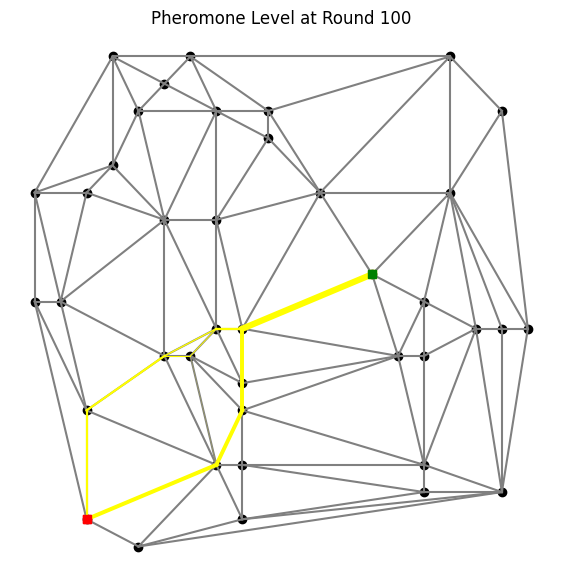

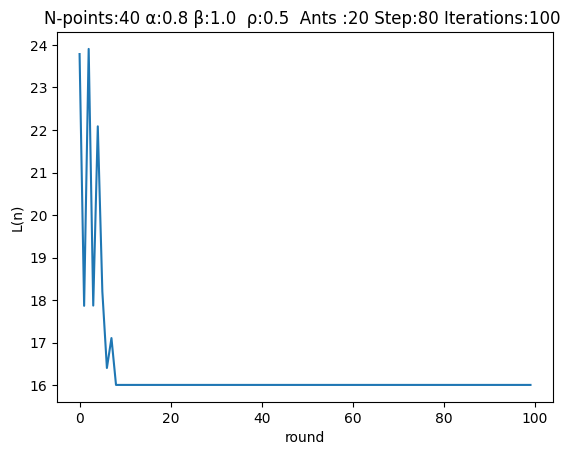

beta value : 1.5


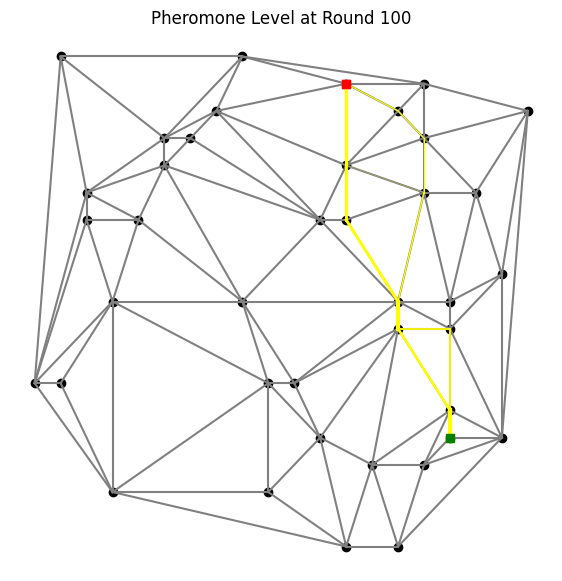

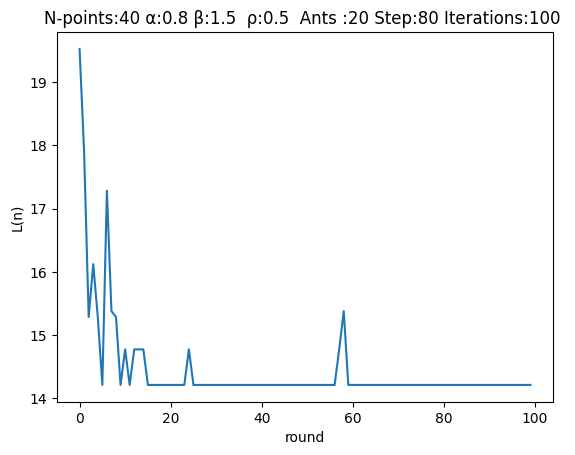

beta value : 2.0


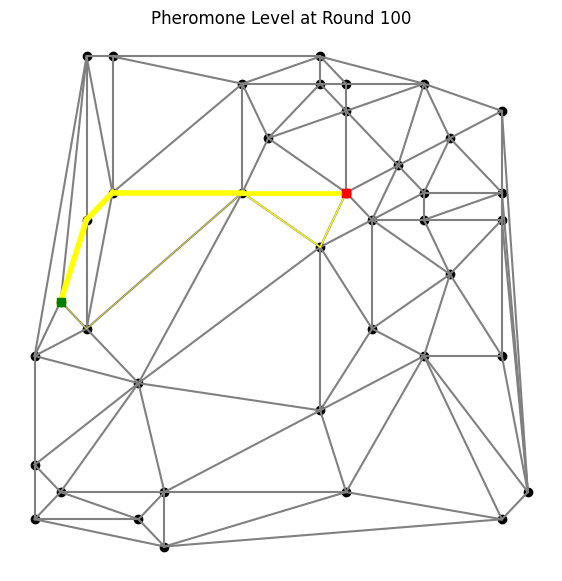

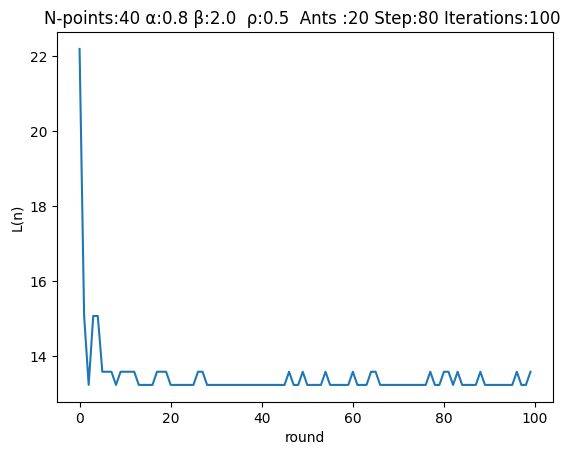

In [63]:
N = 40
alpha = 0.8
beta_list = [1.0,1.5,2.0]
#def ACO_simulation(num_points,num_ants,max_steps,alpha_parameter,beta_parameter,rho_paramter,iterations):
for b in beta_list:
    print(f"beta value : {b}")
    ACO_simulation(
        num_points=N,
        num_ants=A,
        max_steps=S,
        alpha_parameter=alpha,
        beta_parameter=b,
        rho_paramter=rho,
        iterations= iteration_num
    )


#### change rho

rho value : 0.1


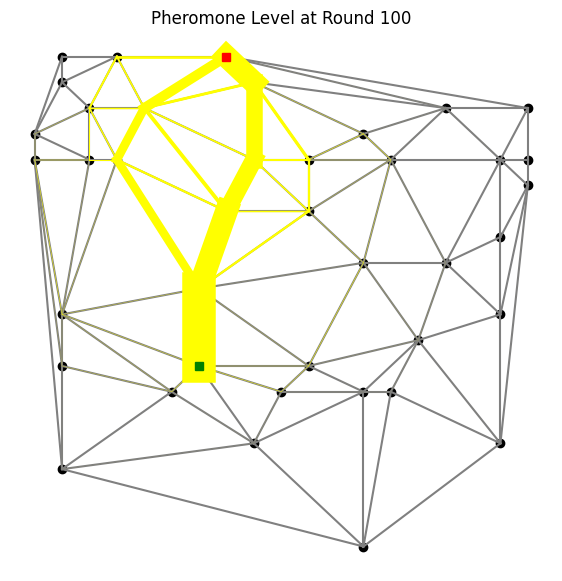

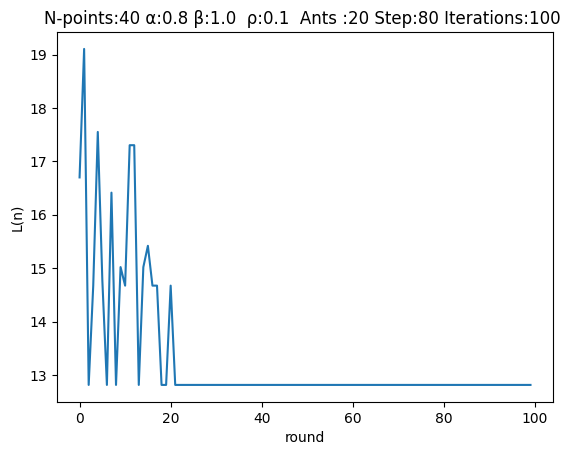

rho value : 0.5


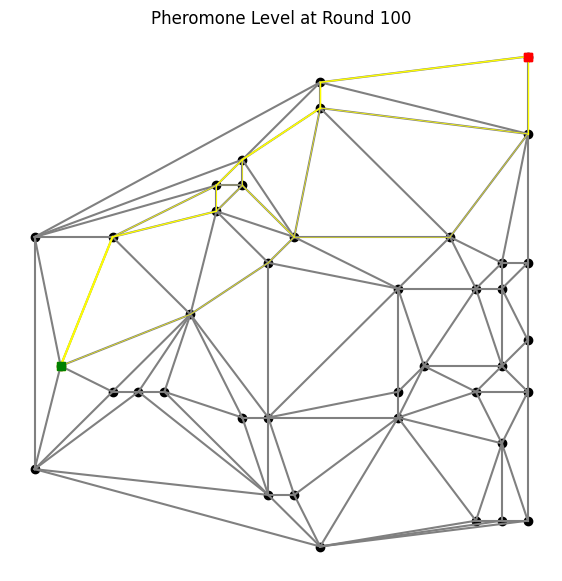

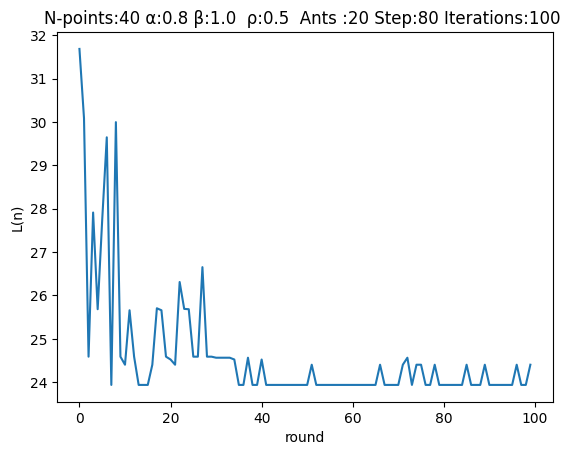

rho value : 0.9


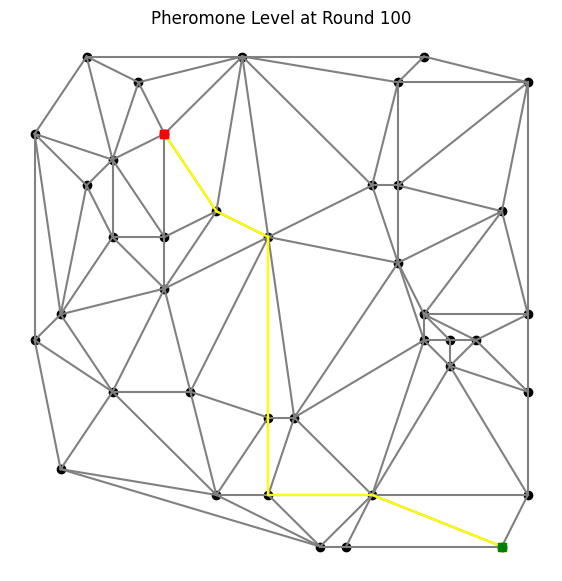

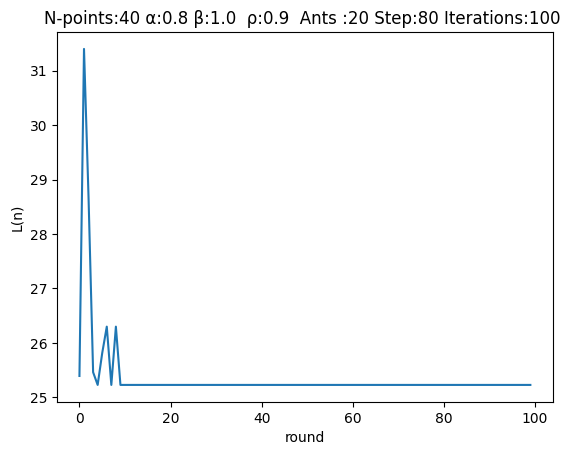

In [64]:
N = 40
alpha = 0.8
beta = 1.0
rho_list = [0.1,0.5,0.9]
#def ACO_simulation(num_points,num_ants,max_steps,alpha_parameter,beta_parameter,rho_paramter,iterations):
for rho in rho_list:
    print(f"rho value : {rho}")
    ACO_simulation(
        num_points=N,
        num_ants=A,
        max_steps=S,
        alpha_parameter=alpha,
        beta_parameter=beta,
        rho_paramter=rho,
        iterations= iteration_num
    )

## 15.8d
#### change number of ants

number pf ants : 10


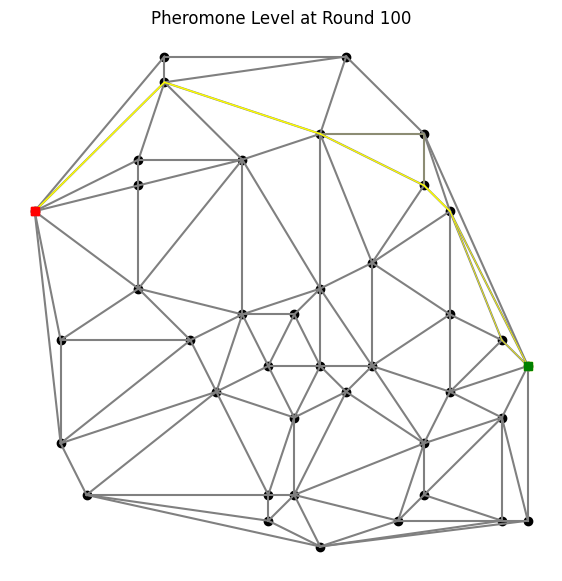

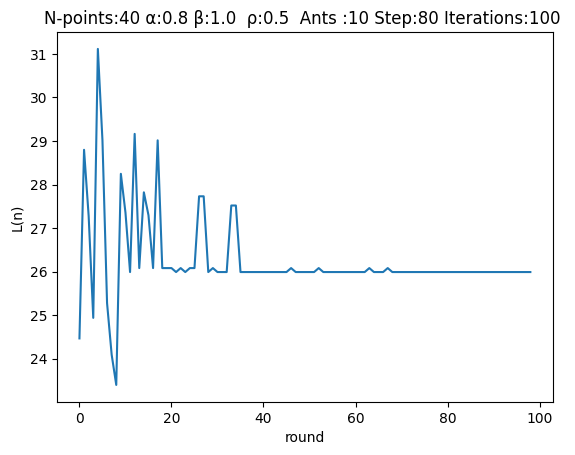

number pf ants : 20


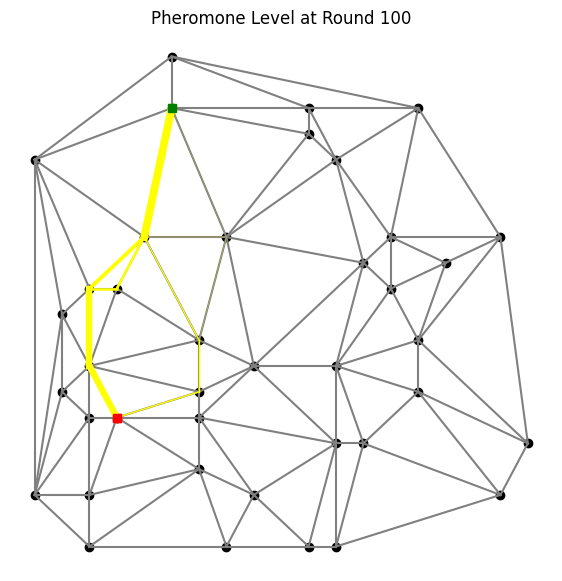

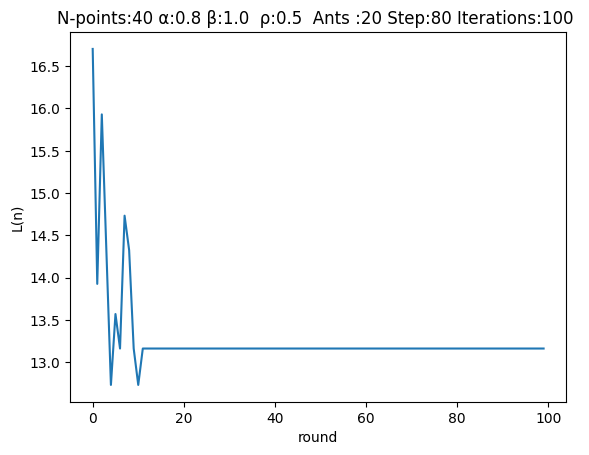

number pf ants : 40


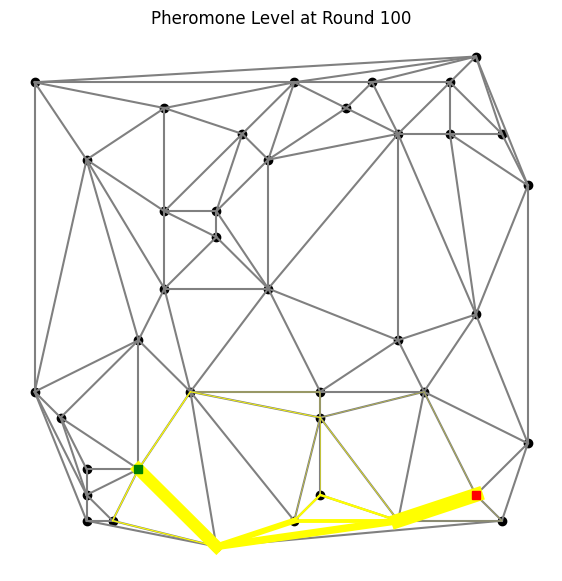

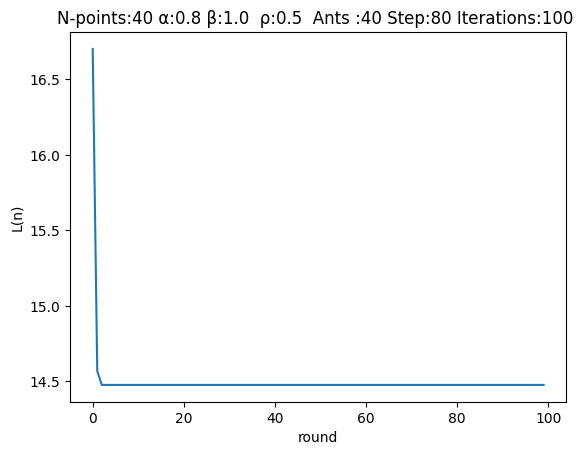

number pf ants : 120


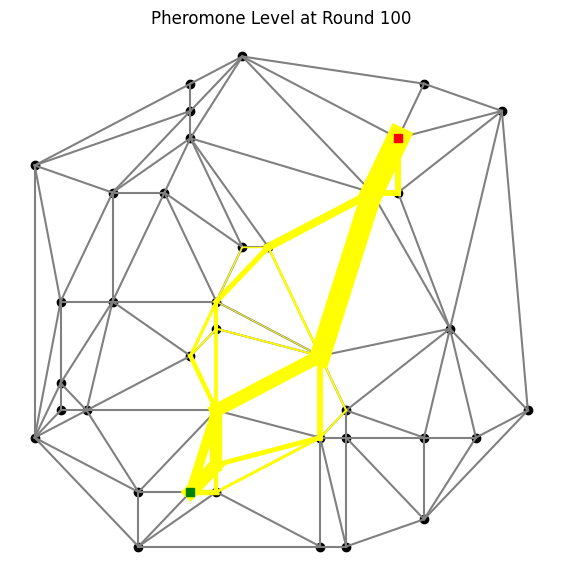

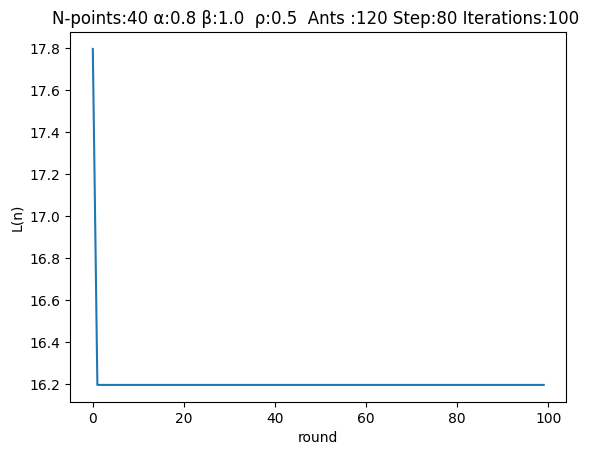

In [79]:
N = 40
alpha = 0.8
beta = 1.0
rho = 0.5
A_list = [10,20,40,120]
#def ACO_simulation(num_points,num_ants,max_steps,alpha_parameter,beta_parameter,rho_paramter,iterations):
for A in A_list:
    print(f"number pf ants : {A}")
    ACO_simulation(
        num_points=N,
        num_ants=A,
        max_steps=S,
        alpha_parameter=alpha,
        beta_parameter=beta,
        rho_paramter=rho,
        iterations= iteration_num
    )

## 15.9 Ants on a noisy square lattice

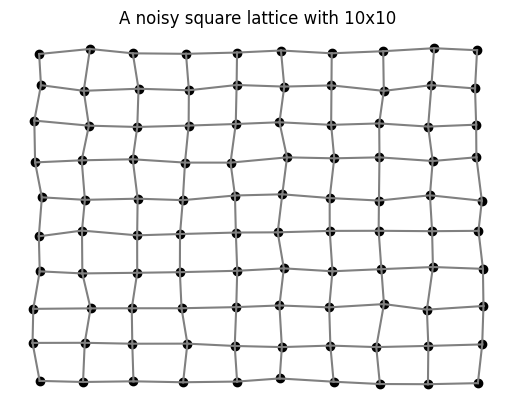

In [66]:
L = 10      #side length of lattice
N = L*L     #number of points in lattice
point_index = []  

noise = 0.1

for i in range(L):
    for j in range(L):
        dif_x = np.random.uniform(-noise,noise)
        dif_y = np.random.uniform(-noise,noise)
        point_index.append([i+dif_x, j+dif_y])

position = np.array([i for i in point_index])

#create connection matrix
# assign all points equal to 1 due to 
M = np.zeros((N,N))
for i in range(L):
    for j in range(L):
        if j < L-1:
            M[i*L+j][i*L+j+1] = 1
            M[i*L+j+1][i*L+j] = 1
        
        if i < L-1:
            M[i*L+j][i*L+j+L] = 1
            M[i*L+j+L][i*L+j] = 1

        
for i in range(N):
    for j in range(i+1,N):

        if M[i,j] == 1:
            plt.plot([position[i,0], position[j, 0]], [position[i,1], position[j,1]], color = 'gray')

plt.scatter(position[:,0], position[:,1], color = 'k')
plt.axis("off")
plt.title(f"A noisy square lattice with {L}x{L}")
plt.show()

In [67]:
def ACO_noisy_simulation(num_ants,max_steps,alpha_parameter,beta_parameter,rho_paramter,iterations,noise_level,lattice_size):
         
    A = num_ants      # number of ants
    S = max_steps      # maximum steps
    alpha = alpha_parameter
    beta = beta_parameter 
    rho = rho_paramter
    iteration_num = iterations
    L = lattice_size     #side length of lattice
    N = L*L     #number of points in lattice
    point_index = []  

    noise = noise_level

    for i in range(L):
        for j in range(L):
            dif_x = np.random.uniform(-noise,noise)
            dif_y = np.random.uniform(-noise,noise)
            point_index.append([i+dif_x, j+dif_y])

    position = np.array([i for i in point_index])

    #create connection matrix
    # assign all points equal to 1 due to 
    M = np.zeros((N,N))
    for i in range(L):
        for j in range(L):
            if j < L-1:
                M[i*L+j][i*L+j+1] = 1
                M[i*L+j+1][i*L+j] = 1
            
            if i < L-1:
                M[i*L+j][i*L+j+L] = 1
                M[i*L+j+L][i*L+j] = 1
    tau = M          # tau = M at the beginning

    # create distance Matrix
    D = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            D[i,j] = np.linalg.norm(position [i] - position[j])
            D[j,i] = D[i,j]

    for i in range(N):
        for j in range(i+1, N):
            if M[i,j] == 0:             # distance inf for disconnected point
                D[i,j] = np.inf
                D[j,i] = np.inf     

    # create weith matrix
    W = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            W[i,j] = 1/D[i,j]

    #   ###################################     #
    best_paths = {'distance' : [], 'sequence': []}

    check_distance = 0 
    while check_distance < 10:              
        s0 = np.random.randint(0, N) # starting point
        f0 = np.random.randint(0, N) # destination point
        check_distance = np.linalg.norm(position[f0] - position[s0])

    for iteration in range(iteration_num):
        paths = []
        paths_length = []
        tau = (1-rho)*tau

        for i in range(A):
            paths.append([s0])      #collect starting point
            for s in range(S):
                current_node = paths[i][-1]
                next_node = branch_decision_rule(current_node,tau,D,M,alpha,beta)
                paths[i].append(next_node)

                if next_node == f0:
                    break
        
        # updata pheromone matrix
        tau = update_pheromone(A,f0,D,paths,paths_length,tau)
        
        #Save best path
        try:
            best_paths["sequence"].append(paths[np.argmin(paths_length)])
            best_paths["distance"].append(min(paths_length))
        except:
            pass

        if iteration == iteration_num - 1:
            plt.figure(figsize=(6, 6))
            plt.plot(position[:, 0], position[:, 1], "o", color = 'k')
            plt.plot(position[s0, 0], position[s0, 1], "s", color="yellow")  # starting point
            plt.plot(position[f0, 0], position[f0, 1], "s", color="r")  # destination point
            
            for i in range(N):
                for j in range(i + 1, N):
                    if M[i, j] == 1:
                        plt.plot([position[i, 0], position[j, 0]], [position[i, 1], position[j, 1]], color='gray',alpha = 0.8)

            for i in range(N):
                for j in range(i + 1, N):
                    plt.plot([position[i, 0], position[j, 0]], [position[i, 1], position[j, 1]], "r", linewidth=tau[i, j] * 2)
            
            plt.title("Pheromone Level at Round " + str(iteration+1))
            plt.plot(position[s0, 0], position[s0, 1], "s", color="g")  # starting point
            plt.plot(position[f0, 0], position[f0, 1], "s", color="r")  # destination point
            plt.plot([position[s0, 0],position[f0,0]], [position[s0, 1],position[f0,1]], color="b",linewidth=10,alpha=0.4)
            plt.axis("off")
            plt.show()

    plt.plot(best_paths["distance"])
    plt.ylabel("L(p)")
    plt.xlabel("round")
    plt.title("N-points:{} α:{} β:{}  ρ:{}  Ants :{} Step:{} Iterations:{} ".format(N, alpha,beta, rho, A, S, iteration_num))
    plt.show()

### 15.9 a

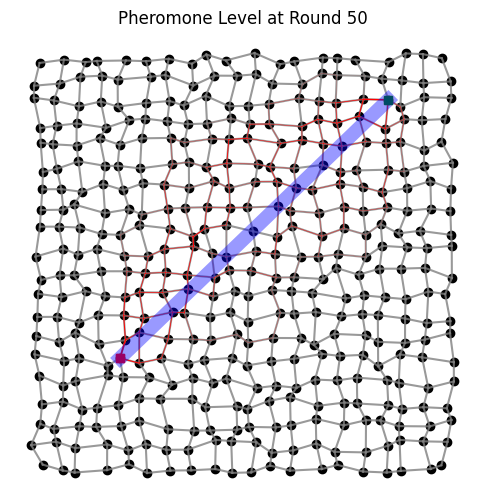

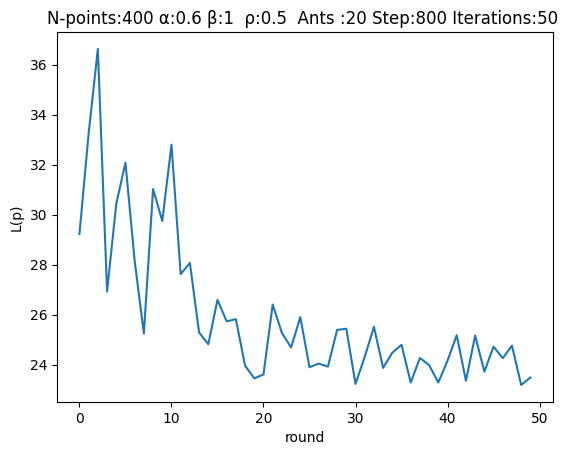

In [73]:
ACO_noisy_simulation(
    
    num_ants = 20,
    max_steps = 800,
    alpha_parameter = 0.6,
    beta_parameter = 1,
    rho_paramter = 0.5,
    iterations = 50,
    noise_level = 0.3,
    lattice_size = 20
    )

## 15.9 b
#### increase 
- number of ant
- max steps
- alpha
- iteration
- rho

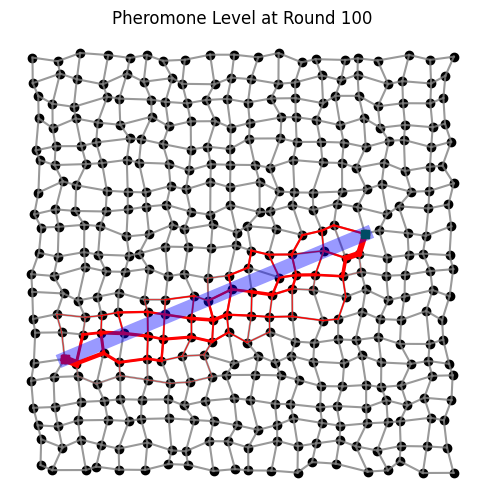

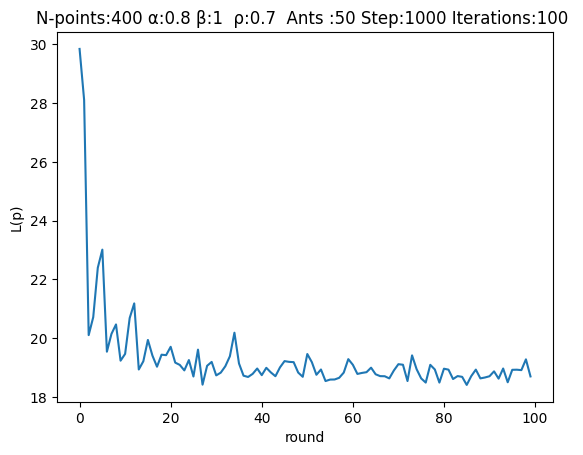

In [80]:
ACO_noisy_simulation(
    
    num_ants = 50,
    max_steps = 1000,
    alpha_parameter = 0.8,
    beta_parameter = 1,
    rho_paramter = 0.7,
    iterations = 100,
    noise_level = 0.3,
    lattice_size = 20
    )

#### 15.9 c

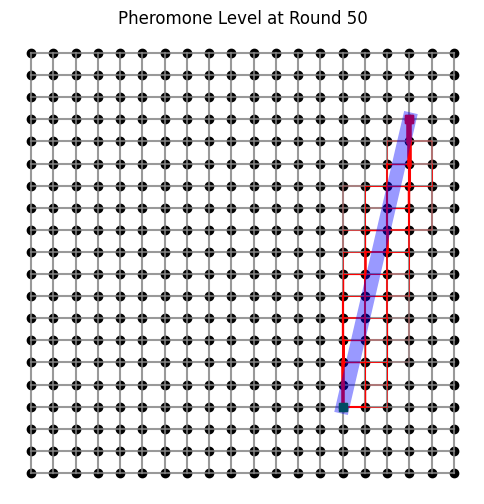

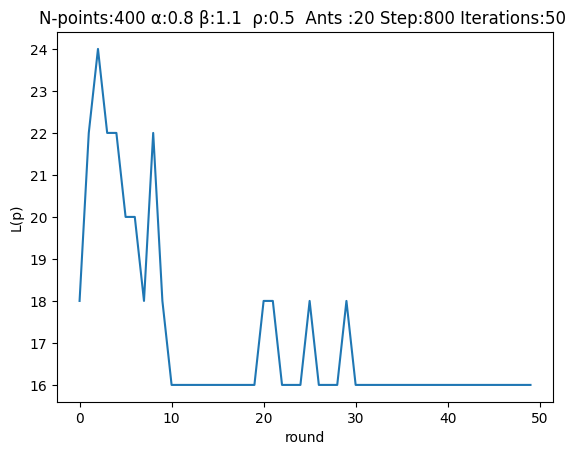

In [70]:
ACO_noisy_simulation(
    
    num_ants=20,
    max_steps=800,
    alpha_parameter=0.8,
    beta_parameter=1.1,
    rho_paramter=0.5,
    iterations=50,
    noise_level=0.0,
    lattice_size=20
    )